<a href="https://colab.research.google.com/github/cod3astro/kaggle_ML_competition/blob/main/colab_kaggle_fertilizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
train_data = pd.read_csv('train.csv', index_col='id')
train_data.head()

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
id,,,,,,,,,
0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,27,69,65,Sandy,Millets,30,6,18,28-28
2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,35,58,43,Red,Paddy,37,2,16,DAP


In [3]:
train_data.shape

(750000, 9)

In [4]:
train_data.drop_duplicates(inplace=True)
train_data.dropna(axis=0)
train_data.describe()

,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,31.503565,61.038912,45.184147,23.093808,9.478296,21.073227
std,4.025574,6.647695,11.794594,11.216125,5.765622,12.346831
min,25.000000,50.000000,25.000000,4.000000,0.000000,0.000000
25%,28.000000,55.000000,35.000000,13.000000,4.000000,10.000000
50%,32.000000,61.000000,45.000000,23.000000,9.000000,21.000000
75%,35.000000,67.000000,55.000000,33.000000,14.000000,32.000000
max,38.000000,72.000000,65.000000,42.000000,19.000000,42.000000


In [5]:
train_data.isnull().any().any()

np.False_

In [6]:
for col in train_data.columns:
  unique_values = train_data[col].unique()
  print(f'{col} ({len(unique_values)} unique)')
  print(train_data[col].unique())

Temparature (14 unique)
[37 27 29 35 30 36 28 32 38 26 34 25 33 31]
Humidity (23 unique)
[70 69 63 62 58 59 51 50 61 60 57 72 68 55 52 64 71 56 66 54 65 67 53]
Moisture (41 unique)
[36 65 32 54 43 29 53 44 35 60 27 42 57 47 50 56 33 37 49 39 30 46 61 64
 26 34 51 48 28 38 52 62 55 40 25 59 31 45 58 41 63]
Soil Type (5 unique)
['Clayey' 'Sandy' 'Red' 'Loamy' 'Black']
Crop Type (11 unique)
['Sugarcane' 'Millets' 'Barley' 'Paddy' 'Pulses' 'Tobacco' 'Ground Nuts'
 'Maize' 'Cotton' 'Wheat' 'Oil seeds']
Nitrogen (39 unique)
[36 30 24 39 37 10 26 19 25 18 34 42 41 15  4  8  6 31 29 20 28 17 27  7
 12 14 35 33  9 16 40 21 23 32 22 11 38 13  5]
Potassium (20 unique)
[ 4  6 12  2  0 15 17  3 19 16  1 13  7  9 14  8 18 11  5 10]
Phosphorous (43 unique)
[ 5 18 16  4  9 22 35 29  2 12 19 39 30 32 34 40 28 33  0  7 13 24 21 27
 17 26  1 36 23 11 10 20 15 41  3 31  6 14 25 42  8 38 37]
Fertilizer Name (7 unique)
['28-28' '17-17-17' '10-26-26' 'DAP' '20-20' '14-35-14' 'Urea']


In [7]:
train_data.columns

Index(['Temparature', 'Humidity', 'Moisture', 'Soil Type', 'Crop Type',
       'Nitrogen', 'Potassium', 'Phosphorous', 'Fertilizer Name'],
      dtype='object')

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [9]:
features = ['Temparature','Nitrogen', 'Soil Type', 'Crop Type', 'Phosphorous', 'Potassium', 'Humidity', 'Moisture']
target = 'Fertilizer Name'
X = train_data[features]
y = train_data[target]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=42)

In [10]:
y.value_counts(normalize=True)

,proportion
Fertilizer Name,
14-35-14,0.152581
10-26-26,0.151849
17-17-17,0.149937
28-28,0.148211
20-20,0.147852
DAP,0.126480
Urea,0.123089


In [11]:
for col in X.select_dtypes('object'):
  X.loc[:, col], _ = X[col].factorize()
discrete_features = X.dtypes == int
y, _ = pd.factorize(y)

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores

,MI Scores
Soil Type,0.005828
Crop Type,0.003870
Moisture,0.003308
Phosphorous,0.002984
Nitrogen,0.002373
Potassium,0.001367
Humidity,0.001015
Temparature,0.000966


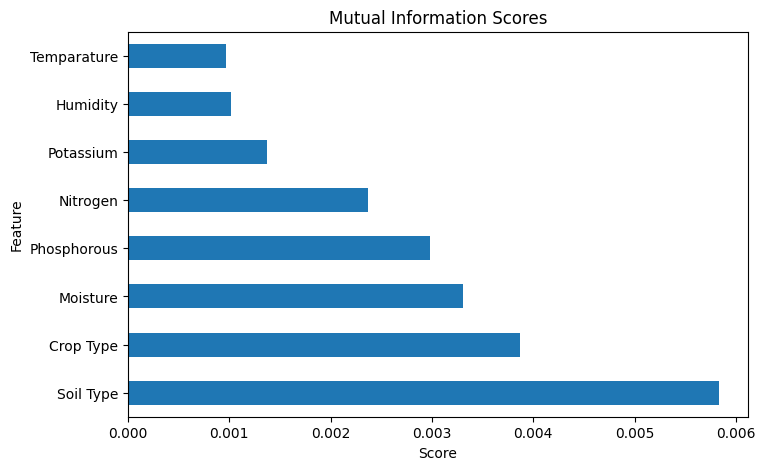

In [12]:
import matplotlib.pyplot as plt

mi_scores.plot(kind="barh", figsize=(8, 5))
plt.title("Mutual Information Scores")
plt.xlabel("Score")
plt.ylabel("Feature")
plt.show()

In [32]:
ordinal_cols = ['Crop Type', 'Soil Type']
numerical_cols = [ 'Nitrogen', 'Phosphorous', 'Potassium', 'Humidity', 'Moisture']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ordinal_cols),
        ('num', 'passthrough', numerical_cols)
    ])
label_encoder = LabelEncoder()
train_y_encoded = label_encoder.fit_transform(train_y)
val_y_encoded = label_encoder.transform(val_y)

decision_tree_model = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(random_state=42))
    ])

decision_tree_model.fit(train_X, train_y_encoded)
y_preds_encoded = decision_tree_model.predict(val_X)
y_preds = label_encoder.inverse_transform(y_preds_encoded)

print("Accuracy:", accuracy_score(val_y, y_preds))
print("Classification Report:", classification_report(val_y, y_preds))

Accuracy: 0.15269866666666668
Classification Report:               precision    recall  f1-score   support

    10-26-26       0.16      0.16      0.16     28487
    14-35-14       0.16      0.16      0.16     28429
    17-17-17       0.16      0.16      0.16     28360
       20-20       0.16      0.16      0.16     27634
       28-28       0.15      0.15      0.15     27937
         DAP       0.14      0.14      0.14     23871
        Urea       0.13      0.13      0.13     22782

    accuracy                           0.15    187500
   macro avg       0.15      0.15      0.15    187500
weighted avg       0.15      0.15      0.15    187500



In [52]:
ordinal_cols = ['Crop Type', 'Soil Type']
numerical_cols = [ 'Nitrogen', 'Phosphorous', 'Potassium', 'Humidity', 'Moisture']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ordinal_cols),
        ('num', 'passthrough', numerical_cols)
    ]
)

label_encoder = LabelEncoder()
train_y_encoded = label_encoder.fit_transform(train_y)
val_y_encoded = label_encoder.transform(val_y)

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(n_estimators=500, learning_rate=0.27, max_depth=6, eval_metric='mlogloss'))
    ]
)

pipeline.fit(train_X, train_y_encoded)
y_preds_encoded = pipeline.predict(val_X)
y_preds = label_encoder.inverse_transform(y_preds_encoded)

print("Accuracy:", accuracy_score(val_y, y_preds))
print("Classification Report:\n", classification_report(val_y, y_preds))
print("Confusion Matrix:\n", confusion_matrix(val_y, y_preds))

Accuracy: 0.20109866666666668
Classification Report:
               precision    recall  f1-score   support

    10-26-26       0.20      0.23      0.21     28487
    14-35-14       0.20      0.24      0.22     28429
    17-17-17       0.21      0.24      0.22     28360
       20-20       0.19      0.20      0.20     27634
       28-28       0.19      0.20      0.20     27937
         DAP       0.21      0.16      0.18     23871
        Urea       0.19      0.12      0.15     22782

    accuracy                           0.20    187500
   macro avg       0.20      0.20      0.20    187500
weighted avg       0.20      0.20      0.20    187500

Confusion Matrix:
 [[6462 4923 4491 4022 4063 2572 1954]
 [4592 6959 4548 4004 3887 2357 2082]
 [4472 4853 6702 3884 3998 2393 2058]
 [4412 4811 4348 5446 4054 2577 1986]
 [4378 4852 4389 4037 5512 2564 2205]
 [3796 3995 3468 3460 3425 3792 1935]
 [3539 3996 3598 3262 3376 2178 2833]]


In [14]:
y_train_preds_encoded = pipeline.predict(train_X[:10])
y_train_preds = label_encoder.inverse_transform(y_train_preds_encoded)

print("Train Predictions (sample):", y_train_preds)
print("True Labels (sample):", train_y[:10].values)

Train Predictions (sample): ['10-26-26' '14-35-14' '10-26-26' '17-17-17' '10-26-26' '20-20' 'DAP'
 '10-26-26' '17-17-17' '10-26-26']
True Labels (sample): ['20-20' '28-28' '17-17-17' '17-17-17' '10-26-26' '14-35-14' '17-17-17'
 '17-17-17' '17-17-17' '28-28']


In [15]:
from sklearn.metrics import log_loss

y_probs = pipeline.predict_proba(val_X)  # Probabilities
loss = log_loss(val_y, y_probs)       # Log loss score
print("Multiclass Log Loss:", loss)

Multiclass Log Loss: 1.9227481189146678


In [16]:
# Training predictions
train_preds = pipeline.predict(train_X)
train_probs = pipeline.predict_proba(train_X)

# Validation predictions
val_preds = pipeline.predict(val_X)
val_probs = pipeline.predict_proba(val_X)

# Accuracy
train_acc = accuracy_score(train_y, train_preds)
val_acc = accuracy_score(val_y, val_preds)

# Log Loss
train_logloss = log_loss(train_y, train_probs)
val_logloss = log_loss(val_y, val_probs)

print("Train Accuracy:", train_acc)
print("Validation Accuracy:", val_acc)
print("Train Log Loss:", train_logloss)
print("Validation Log Loss:", val_logloss)

Train Accuracy: 0.0
Validation Accuracy: 0.0
Train Log Loss: 1.8902845621405902
Validation Log Loss: 1.9227481189146678


In [17]:
tren_data = train_data.copy()
tren_data['NPK_Total'] = tren_data[['Nitrogen', 'Potassium', 'Phosphorous']].sum(axis=1).replace(0, 1)
tren_data['N_Ratio'] = tren_data['Nitrogen'] / tren_data['NPK_Total']
tren_data['P_Ratio'] = tren_data['Phosphorous'] / tren_data['NPK_Total']
tren_data['K_Ratio'] = tren_data['Potassium'] / tren_data['NPK_Total']
tren_data["Temperature_norm"] = (tren_data["Temparature"] - tren_data["Temparature"].min()) / (tren_data["Temparature"].max() - tren_data["Temparature"].min())
tren_data["Humidity_norm"] = (tren_data["Humidity"] - tren_data["Humidity"].min()) / (tren_data["Humidity"].max() - tren_data["Humidity"].min())
tren_data["Moisture_norm"] = (tren_data["Moisture"] - tren_data["Moisture"].min()) / (tren_data["Moisture"].max() - tren_data["Moisture"].min())

# Simple weather stress index
tren_data["WeatherIndex"] = (tren_data["Temperature_norm"] + tren_data["Humidity_norm"] + tren_data["Moisture_norm"]) / 3

In [18]:
feature_ratio = ['Temparature','Nitrogen', 'Soil Type', 'Crop Type', 'Phosphorous', 'Potassium', 'Humidity', 'Moisture', 'WeatherIndex', 'N_Ratio', 'P_Ratio', 'K_Ratio', 'NPK_Total']
target_ratio = 'Fertilizer Name'
A = tren_data[feature_ratio]
b = tren_data[target_ratio]
tren_A, val_A, tren_b, val_b = train_test_split(A, b, random_state=42)

In [19]:
ordinal_cols = ['Crop Type', 'Soil Type']
numerical_cols = [ 'Nitrogen', 'Phosphorous', 'Potassium', 'Humidity', 'Moisture', 'WeatherIndex', 'N_Ratio', 'NPK_Total']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ordinal_cols),
        ('num', 'passthrough', numerical_cols)
    ]
)

label_encoder = LabelEncoder()
tren_b_encoded = label_encoder.fit_transform(tren_b)
val_b_encoded = label_encoder.transform(val_b)

model = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(eval_metric='mlogloss'))
    ]
)

model.fit(tren_A, tren_b_encoded)
b_preds_encoded = model.predict(val_A)
b_preds = label_encoder.inverse_transform(b_preds_encoded)

print("Accuracy:", accuracy_score(val_b, b_preds))
print("Classification Report:\n", classification_report(val_b, b_preds))
print("Confusion Matrix:\n", confusion_matrix(val_b, b_preds))

Accuracy: 0.18933866666666666
Classification Report:
               precision    recall  f1-score   support

    10-26-26       0.19      0.22      0.20     28487
    14-35-14       0.19      0.26      0.22     28429
    17-17-17       0.20      0.23      0.21     28360
       20-20       0.19      0.20      0.19     27634
       28-28       0.18      0.20      0.19     27937
         DAP       0.19      0.12      0.15     23871
        Urea       0.18      0.07      0.10     22782

    accuracy                           0.19    187500
   macro avg       0.19      0.18      0.18    187500
weighted avg       0.19      0.19      0.18    187500

Confusion Matrix:
 [[6200 5547 4873 4124 4524 2049 1170]
 [4850 7346 4809 4083 4122 1928 1291]
 [4726 5532 6489 4069 4305 1992 1247]
 [4721 5340 4567 5426 4286 2061 1233]
 [4536 5617 4584 4215 5509 2110 1366]
 [4149 4481 3887 3595 3674 2884 1201]
 [3911 4545 3901 3334 3676 1768 1647]]


In [20]:
ordinal_cols = ['Crop Type', 'Soil Type']
numerical_cols = [ 'Nitrogen', 'Phosphorous', 'Potassium', 'Humidity', 'Moisture', 'WeatherIndex']

preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinal_cols),
        ('num', 'passthrough', numerical_cols)
    ]
)

label_encoder = LabelEncoder()
tren_b_encoded = label_encoder.fit_transform(tren_b)
val_b_encoded = label_encoder.transform(val_b)

model = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(eval_metric='mlogloss'))
    ]
)

model.fit(tren_A, tren_b_encoded)
b_preds_encoded = model.predict(val_A)
b_preds = label_encoder.inverse_transform(b_preds_encoded)

print("Accuracy:", accuracy_score(val_b, b_preds))
print("Classification Report:\n", classification_report(val_b, b_preds))
print("Confusion Matrix:\n", confusion_matrix(val_b, b_preds))

Accuracy: 0.190272
Classification Report:
               precision    recall  f1-score   support

    10-26-26       0.19      0.21      0.20     28487
    14-35-14       0.19      0.26      0.22     28429
    17-17-17       0.20      0.23      0.21     28360
       20-20       0.19      0.20      0.19     27634
       28-28       0.18      0.20      0.19     27937
         DAP       0.20      0.12      0.15     23871
        Urea       0.18      0.08      0.11     22782

    accuracy                           0.19    187500
   macro avg       0.19      0.19      0.18    187500
weighted avg       0.19      0.19      0.19    187500

Confusion Matrix:
 [[6067 5521 4792 4280 4381 2124 1322]
 [4738 7359 4706 4063 4161 1948 1454]
 [4570 5506 6528 4155 4316 1903 1382]
 [4635 5142 4629 5512 4279 2101 1336]
 [4392 5502 4626 4324 5476 2163 1454]
 [3958 4483 3782 3617 3769 2940 1322]
 [3735 4466 3835 3461 3660 1831 1794]]


In [53]:
test_data = pd.read_csv('test.csv')
test_X = test_data[features]
test_preds_encoded = pipeline.predict(test_X)

test_preds = label_encoder.inverse_transform(test_preds_encoded)

submission013 = pd.DataFrame({
    'ID': test_data['id'],
    'Fertilizer Name': test_preds
})

submission013.to_csv('submission013.csv', index=False)

from google.colab import files
files.download('submission013.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>